# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
 
Целевой признак:

* Price — цена (евро)

## Подготовка данных

In [1]:
# Загрузим все необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt 
plt.style.use('seaborn-pastel')
import seaborn as sns 
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from category_encoders import TargetEncoder

from time import time
from tqdm import tqdm

pd.options.display.max_columns = None # полностью отображаем столбцы

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('D:/DS/datasets/autos.csv')
    
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Признаки:

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
 
Целевой признак:

* Price — цена (евро)

Удалим дубликаты:

In [4]:
print(df.duplicated().sum())

df = df.drop_duplicates().reset_index(drop=True)

4


In [5]:
for col in ['DateCrawled', 'DateCreated', 'LastSeen']:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

Мы изменили тип колонок, связанные со временем, но колонки `RegistrationMonth` и `RegistrationYear` мы отнесем к численным признакам, которые могут помочь модели обучения.

Создадим списки колонок, чтоьы рассмотреть все характеристики столбцов:

In [6]:
num_cols = []
date_cols = []
cat_cols = []

for i in range(len(df.columns)):
    if df.dtypes[i] == 'int64':
        num_cols.append(df.columns[i])
    elif df.dtypes[i] == 'datetime64[ns]':
        date_cols.append(df.columns[i])
    else:
        cat_cols.append(df.columns[i])
        
print(num_cols, '\n',date_cols, '\n', cat_cols)

['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode'] 
 ['DateCrawled', 'DateCreated', 'LastSeen'] 
 ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']


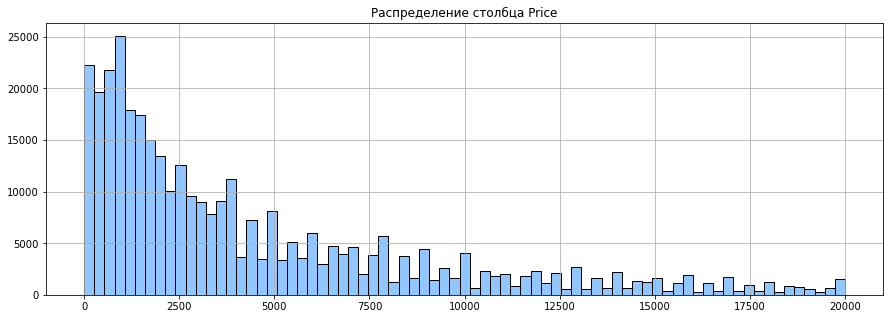

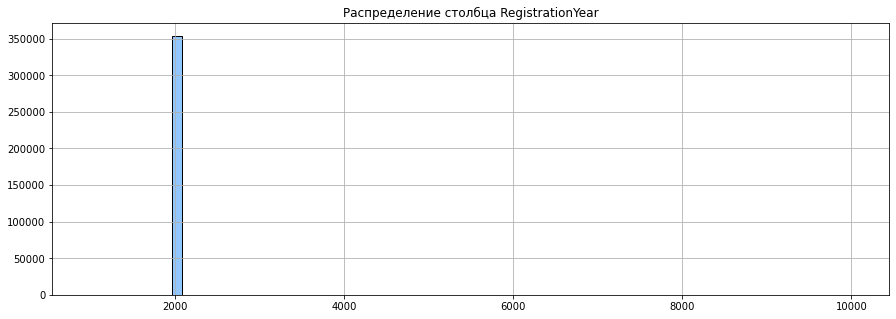

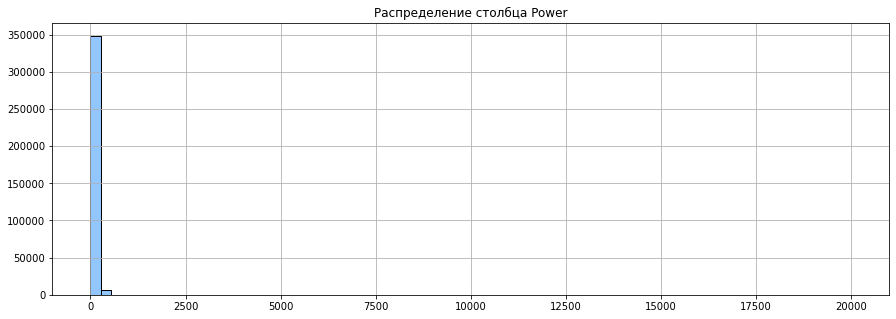

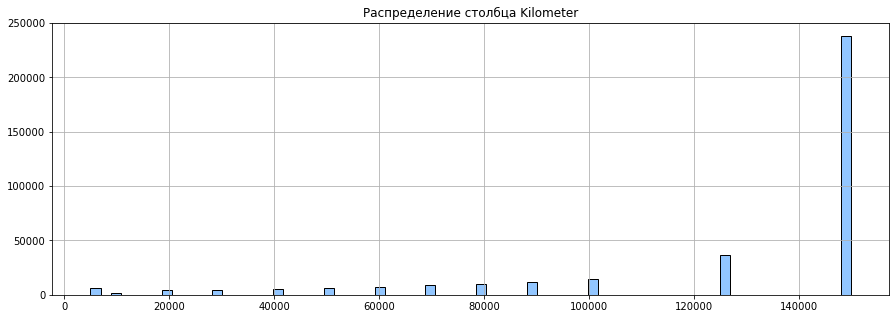

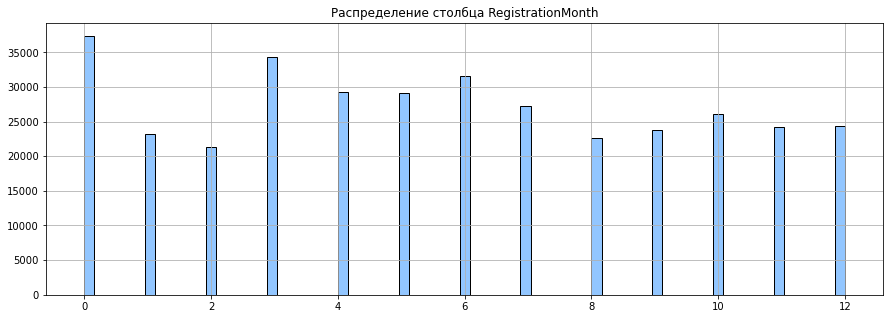

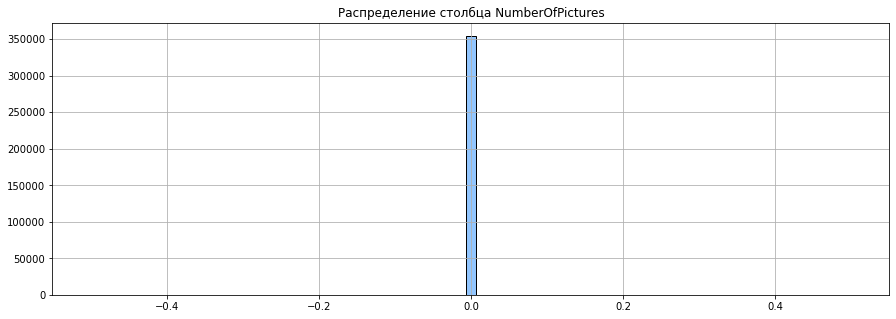

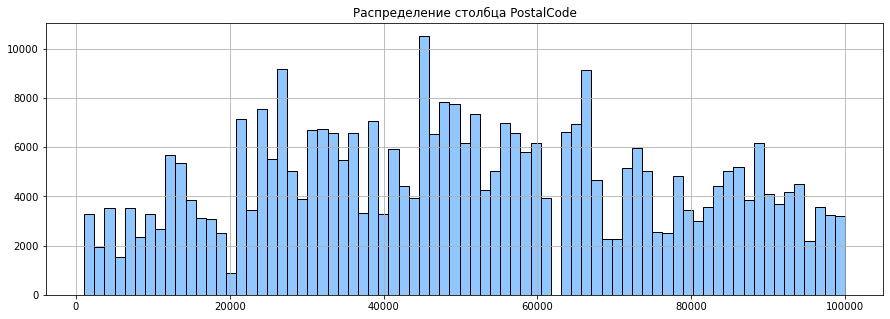

In [7]:
# Рассмотрим гистограммы столбцов
for column in num_cols:
    plt.figure(figsize=(15,5))
    df[column].hist(bins=75, edgecolor='k')
    plt.title(f'Распределение столбца {column}')
    plt.show()

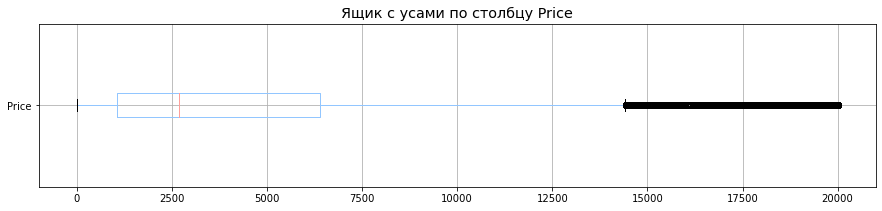

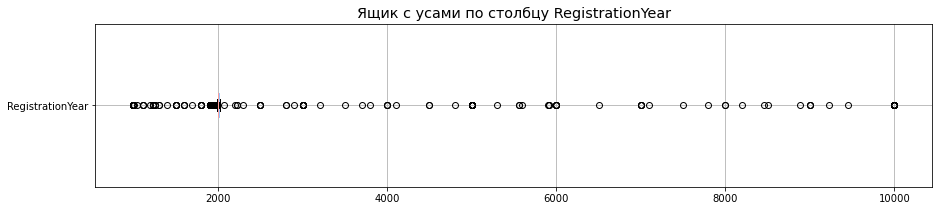

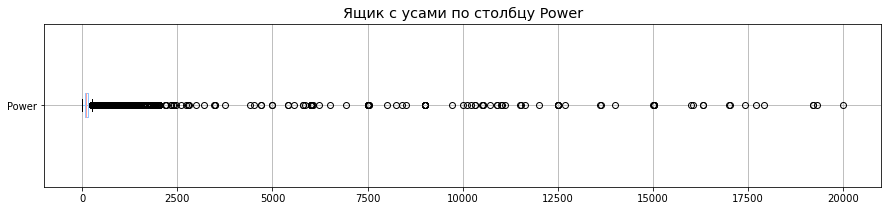

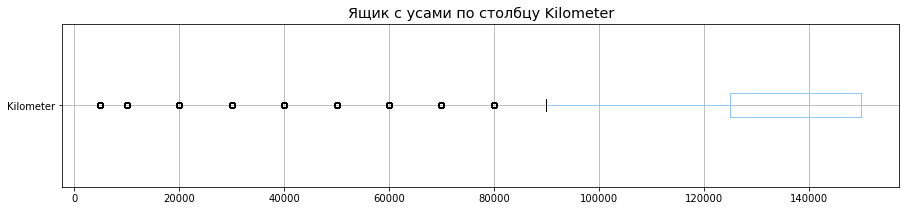

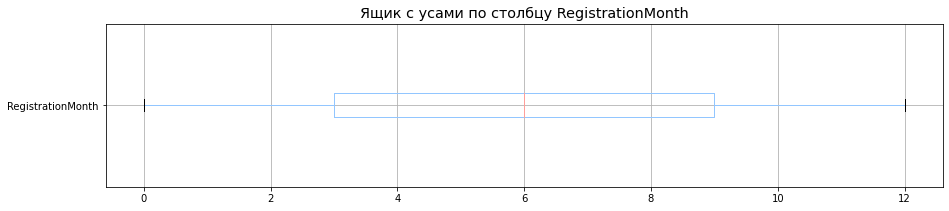

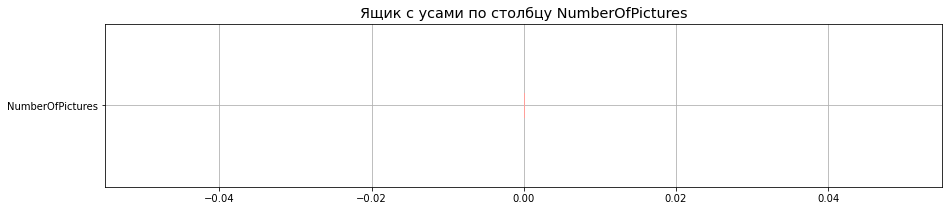

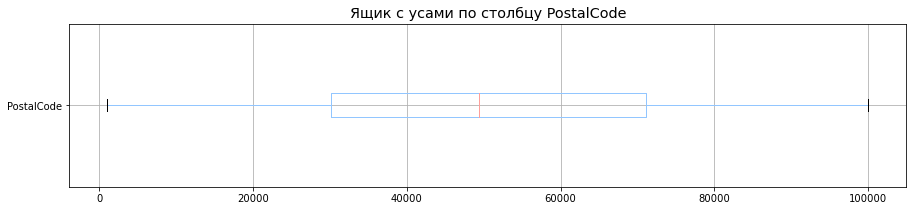

In [8]:
# рассмотрим выбросы по столбцам
for col in num_cols:
    plt.figure(figsize=(15,3))
    df.boxplot(col, vert=False)
    plt.title(f'Ящик с усами по столбцу {col}', fontsize='x-large')
    plt.show()

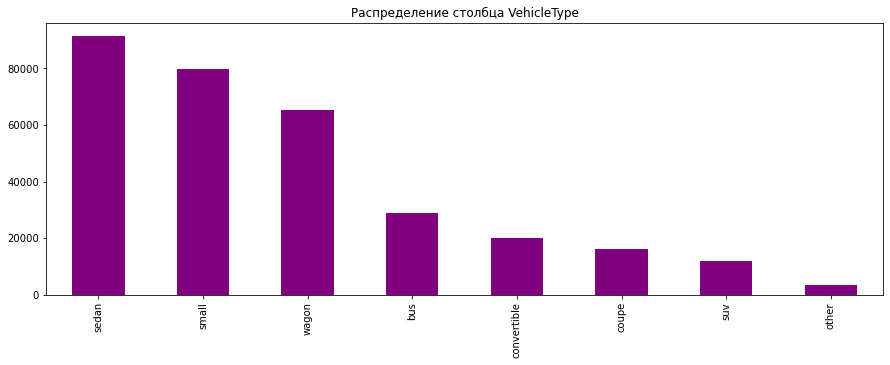

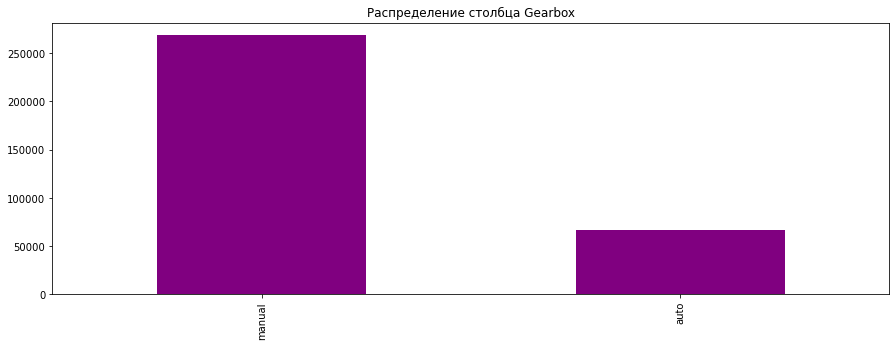

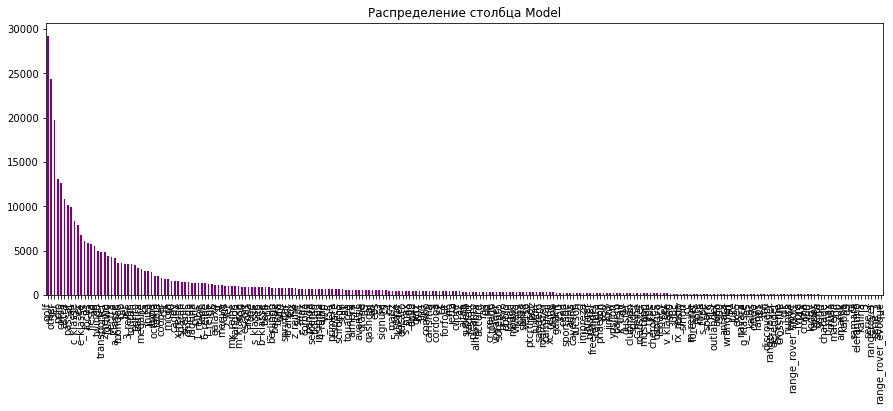

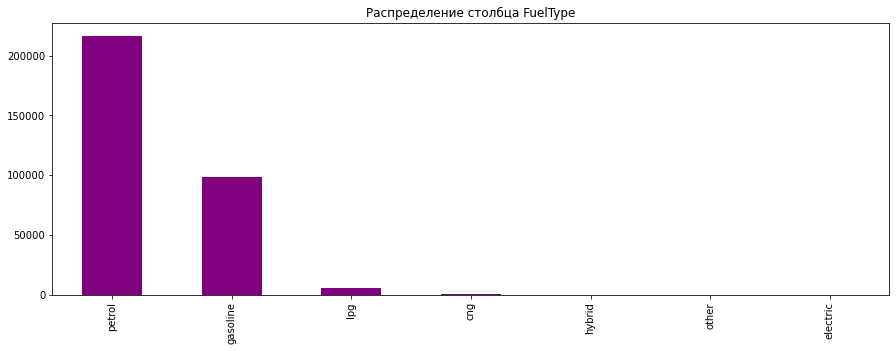

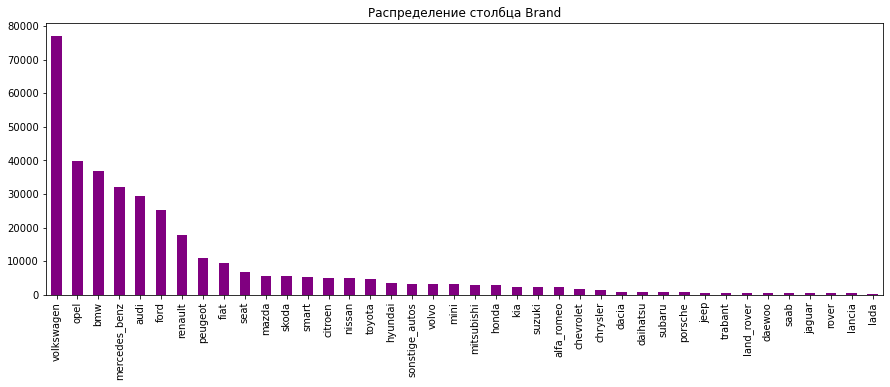

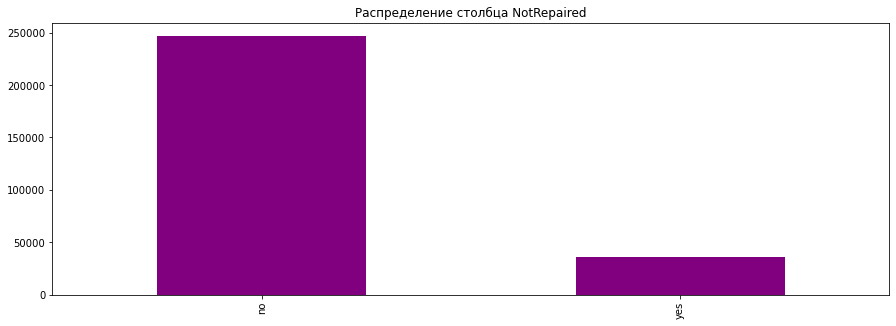

In [9]:
# рассмотрим категориальные признаки
for column in cat_cols:
    plt.figure(figsize=(15,5))
    df[column].value_counts().plot.bar(color='purple', rot=90)
    plt.title(f'Распределение столбца {column}')
    plt.show()

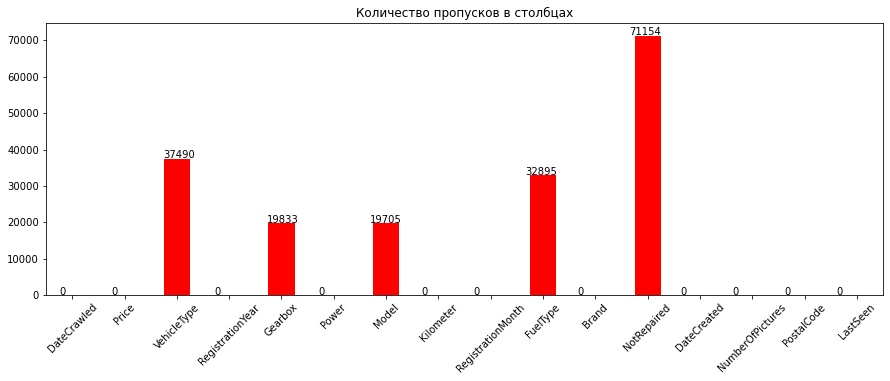

In [10]:
# рассмотрим пропуски в столбцах

plt.figure(figsize=(15,5))
ax = df.isna().sum().plot.bar(color='red', rot=45)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 0.99, p.get_height() * 1.005))
plt.title('Количество пропусков в столбцах')
plt.show()

___

**Выводы:**

* В некоторых столбцах присутствуют выбросы, причем очень странного характера. Скорее всего это артефакты
* Есть пропуски значений в категориальных столбцах. В численных нет.
* Столбец с количеством фотографии - не содержит ничего. Все значения 0.

Чтобы не удалять много строк с пустыми значениями, заполним все категориальные значения значением `unknown`

In [11]:
df = df.fillna('unknown')

Рассмотрим артефакты:

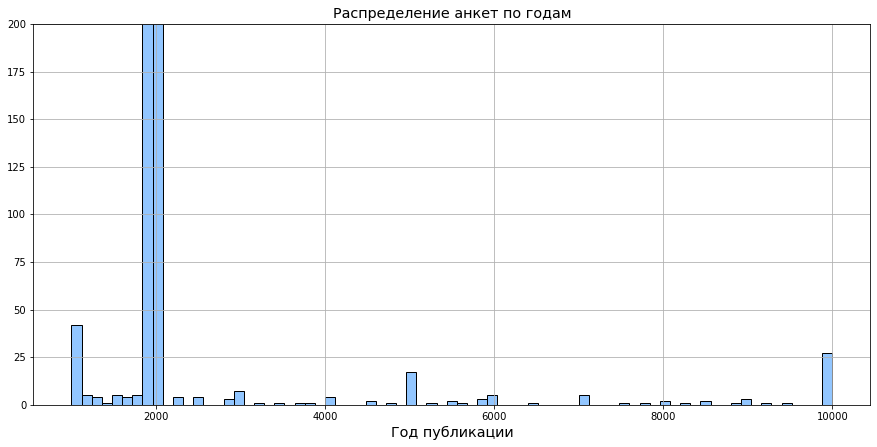

In [12]:
plt.figure(figsize=(15,7))
plt.ylim(0,200)
df['RegistrationYear'].hist(bins=75, edgecolor='k')
plt.title('Распределение анкет по годам', fontsize='x-large')
plt.xlabel('Год публикации', fontsize='x-large')
plt.show()

In [13]:
display(df.query('RegistrationYear < 1920 or RegistrationYear >= 2022').head(),
        df.query('RegistrationYear < 1920 or RegistrationYear >= 2022').tail())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
15,2016-03-11 21:39:15,450,small,1910,unknown,0,ka,5000,0,petrol,ford,unknown,2016-03-11,0,24148,2016-03-19 08:46:47
622,2016-03-16 16:55:09,0,unknown,1111,unknown,0,unknown,5000,0,unknown,opel,unknown,2016-03-16,0,44628,2016-03-20 16:44:37
6629,2016-04-02 13:47:16,0,small,1910,unknown,0,unknown,5000,1,other,sonstige_autos,unknown,2016-04-02,0,93105,2016-04-04 11:16:30
6977,2016-03-24 08:37:22,135,unknown,1910,unknown,0,unknown,5000,0,unknown,opel,unknown,2016-03-24,0,19374,2016-04-06 20:46:08
10183,2016-03-27 13:59:08,1250,unknown,1910,unknown,0,other,5000,0,unknown,audi,unknown,2016-03-27,0,18445,2016-04-07 10:45:31


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
341787,2016-03-28 17:37:30,1,unknown,3000,unknown,0,zafira,5000,0,unknown,opel,unknown,2016-03-28,0,26624,2016-04-02 22:17:49
343079,2016-04-01 08:51:08,1,other,1910,unknown,0,unknown,5000,1,other,volkswagen,unknown,2016-04-01,0,18273,2016-04-07 05:44:39
348826,2016-03-22 00:38:15,1,unknown,1000,unknown,1000,unknown,150000,0,unknown,sonstige_autos,unknown,2016-03-21,0,41472,2016-04-05 14:18:01
351678,2016-03-12 00:57:39,11500,unknown,1800,unknown,16,other,5000,6,petrol,fiat,unknown,2016-03-11,0,16515,2016-04-05 19:47:27
353957,2016-03-17 13:54:22,200,unknown,1910,unknown,0,unknown,5000,0,petrol,sonstige_autos,unknown,2016-03-17,0,42289,2016-03-31 22:46:47


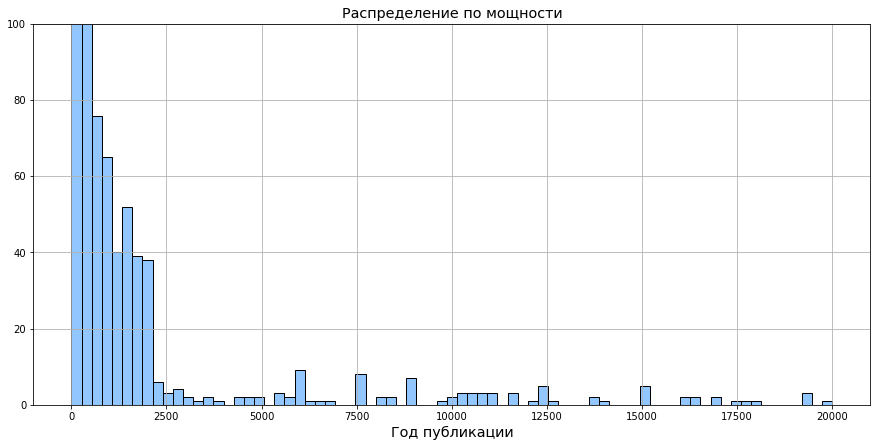

In [14]:
plt.figure(figsize=(15,7))
plt.ylim(0,100)
df['Power'].hist(bins=75, edgecolor='k')
plt.title('Распределение по мощности', fontsize='x-large')
plt.xlabel('Год публикации', fontsize='x-large')
plt.show()

In [15]:
df.query('Power >= 600')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22,0,22043,2016-03-22 21:43:26
2102,2016-03-21 11:55:22,0,sedan,1999,unknown,1799,vectra,150000,1,petrol,opel,yes,2016-03-21,0,1723,2016-04-04 04:49:06
3746,2016-03-21 14:48:31,0,unknown,2017,manual,750,unknown,150000,8,petrol,smart,no,2016-03-21,0,49356,2016-03-24 03:44:59
4060,2016-04-03 20:31:00,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016-04-03,0,60326,2016-04-07 14:56:46
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,unknown,2016-03-29,0,33154,2016-04-06 05:44:36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348964,2016-04-04 18:53:25,250,small,1999,manual,1241,ypsilon,150000,5,petrol,lancia,yes,2016-04-04,0,28259,2016-04-04 18:53:25
351943,2016-03-07 21:36:19,1500,bus,2001,manual,1001,zafira,5000,7,gasoline,opel,no,2016-03-07,0,66117,2016-03-09 12:47:08
353489,2016-04-02 20:54:21,12500,unknown,2017,manual,2000,other,60000,0,gasoline,chrysler,no,2016-04-02,0,44145,2016-04-06 21:44:39
353629,2016-03-23 23:55:21,2400,sedan,2007,manual,650,c2,150000,8,petrol,citroen,unknown,2016-03-23,0,45277,2016-03-27 01:15:17


В двух столбцах замечены выбросы, которые могут повлиять на модель приобучении.

Соотвественно, удалим лишние строки с выбросами в годах. Их всего 171. 

И также очистим строки с мощностью машин более 600 л.с - 394 строк.

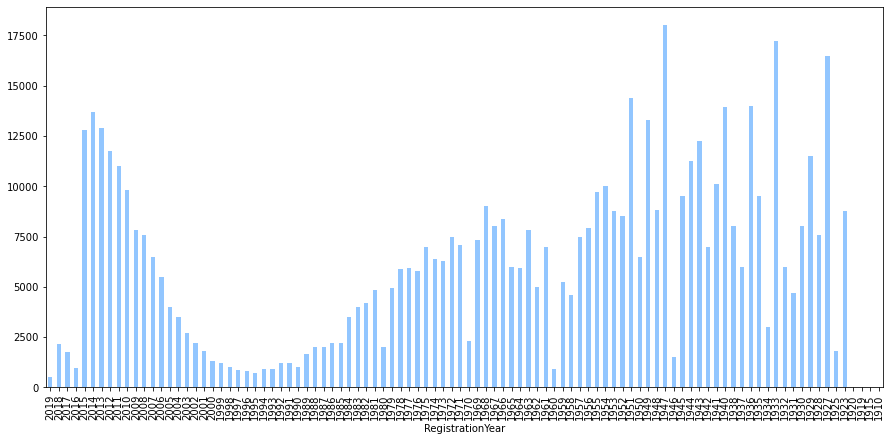

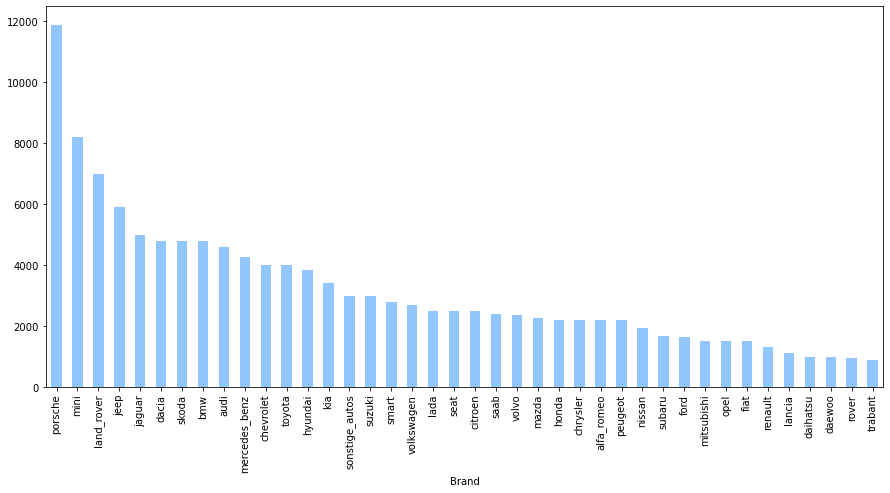

In [16]:
plt.figure(figsize=(15,7))
df.query('RegistrationYear >= 1885 and RegistrationYear <= 2022')\
    .groupby(['RegistrationYear']).median()\
    .sort_values(by='RegistrationYear', ascending=False)['Price']\
    .plot.bar()
plt.show()

plt.figure(figsize=(15,7))
df.groupby('Brand').median()['Price'].sort_values(ascending=False).plot.bar()
plt.show()

In [17]:
df = df.drop(df.query('Power >= 600').index).reset_index(drop=True)
df = df.drop(df.query('RegistrationYear < 1920 or RegistrationYear >= 2022').index).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353710 entries, 0 to 353709
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        353710 non-null  datetime64[ns]
 1   Price              353710 non-null  int64         
 2   VehicleType        353710 non-null  object        
 3   RegistrationYear   353710 non-null  int64         
 4   Gearbox            353710 non-null  object        
 5   Power              353710 non-null  int64         
 6   Model              353710 non-null  object        
 7   Kilometer          353710 non-null  int64         
 8   RegistrationMonth  353710 non-null  int64         
 9   FuelType           353710 non-null  object        
 10  Brand              353710 non-null  object        
 11  NotRepaired        353710 non-null  object        
 12  DateCreated        353710 non-null  datetime64[ns]
 13  NumberOfPictures   353710 non-null  int64   

Так же отбросим столбцы, которые никак не повлияют на модель машинного обучения (являются индивидуальными параметрами пользователя или датасета):

* DateCrawled — дата скачивания анкеты из базы
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля (так как в столбце нет значений кроме `0`)
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

In [18]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

> Снова проверим дубликаты и удалим их:

In [19]:
print(df.duplicated().sum())

df = df.drop_duplicates().reset_index(drop=True)

27508


Проверим корреляцию параметров:

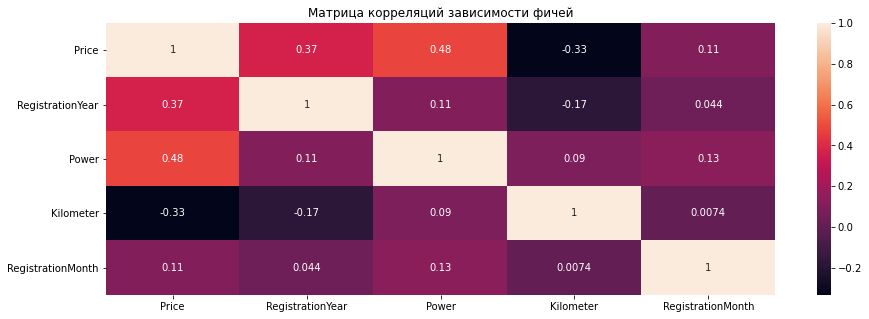

In [20]:
plt.figure(figsize=(15, 5))
plt.title('Матрица корреляций зависимости фичей')

sns.heatmap(df.corr(), annot = True)

plt.show()

Нет значений, сильно коррелирующих между собой (больше 0.7), но некоторые параметры, коррелируют с целевым параметром сильнее, это может улучшить качество модели.

Данные подготовлены, можно приступать к обучению моделей.

Прежде, чем обучать модель, подготовим данные для обработки:

* Применим OHE только для признаков, где мало разных признаков. То есть не будем брать признак `Model`
* Разделим выборку на тренировочную и тестовую
* Заменим 0 в целевом признаке на тренировочной выборке
* обучим на тренировочной выборке TargetEncoder на признаке `Model` и применим, повторим на тестовой 
* применим стандартизацию
* добавим в тренировочную и тестовую выборку столбцы из OHE, чтобы сходилось количество признаков

In [21]:
# удаляем нужный столбец из категорий для обработки

cat_cols.remove('Model')

OHE:

In [22]:
df_ohe = pd.get_dummies(df, columns=cat_cols, drop_first=True)

df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326202 entries, 0 to 326201
Data columns (total 64 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Price                    326202 non-null  int64 
 1   RegistrationYear         326202 non-null  int64 
 2   Power                    326202 non-null  int64 
 3   Model                    326202 non-null  object
 4   Kilometer                326202 non-null  int64 
 5   RegistrationMonth        326202 non-null  int64 
 6   VehicleType_convertible  326202 non-null  uint8 
 7   VehicleType_coupe        326202 non-null  uint8 
 8   VehicleType_other        326202 non-null  uint8 
 9   VehicleType_sedan        326202 non-null  uint8 
 10  VehicleType_small        326202 non-null  uint8 
 11  VehicleType_suv          326202 non-null  uint8 
 12  VehicleType_unknown      326202 non-null  uint8 
 13  VehicleType_wagon        326202 non-null  uint8 
 14  Gearbox_manual      

Так как мы будем заменять нули на тренировочной выборке, стоит разделить на начальном датасете и выполнить предобработку:

In [23]:
train, test = train_test_split(df,
                               test_size=0.20,
                               random_state=12345)

print('Размер тренировочной выборки:', train.shape,
      '\nРазмер тестовой выборки:', test.shape)

Размер тренировочной выборки: (260961, 11) 
Размер тестовой выборки: (65241, 11)


Заменим нули на трейне на пустые значения для заполнения:

In [24]:
train['Price'] = train['Price'].replace(0, np.nan)

train['Price'].isna().sum()

<ipython-input-24-df0b89db05e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Price'] = train['Price'].replace(0, np.nan)


7479

In [25]:
train['Price'] = train['Price'].fillna(train.groupby(['RegistrationYear', 'Brand'])['Price'].transform('median'))

train[train['Price'].isna()]

<ipython-input-25-605fadedafc5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Price'] = train['Price'].fillna(train.groupby(['RegistrationYear', 'Brand'])['Price'].transform('median'))


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
231382,NaN,unknown,1948,unknown,0,unknown,5000,0,unknown,opel,unknown
117362,NaN,unknown,1980,unknown,0,300c,150000,0,unknown,chrysler,unknown
108726,NaN,unknown,1980,manual,90,unknown,70000,0,petrol,mazda,unknown
62526,NaN,suv,1986,manual,99,pajero,125000,0,unknown,mitsubishi,unknown
219034,NaN,unknown,1980,unknown,0,rx_reihe,5000,0,unknown,mazda,unknown
263924,NaN,other,1920,unknown,0,unknown,5000,1,other,sonstige_autos,unknown
149355,NaN,convertible,1971,manual,75,other,125000,0,petrol,peugeot,unknown
44275,NaN,small,1987,auto,76,unknown,90000,10,petrol,kia,unknown
232203,NaN,unknown,2019,manual,0,twingo,150000,2,petrol,renault,yes
251449,NaN,other,1970,manual,0,other,5000,0,other,daihatsu,yes


Оставшиеся пропуски заполним по году регистрации машины через медиану:

In [26]:
train['Price'] = train['Price'].fillna(train.groupby(['RegistrationYear'])['Price'].transform('median'))

train[train['Price'].isna()]

<ipython-input-26-f9546c7ecb61>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Price'] = train['Price'].fillna(train.groupby(['RegistrationYear'])['Price'].transform('median'))


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
263924,NaN,other,1920,unknown,0,unknown,5000,1,other,sonstige_autos,unknown


Так как оставшаяся срока - раритетная машина, где цена была указана 0 - можно строкой пренебречь.

In [27]:
train = train.dropna()

Закодируем модель машин через TargetEncoder и будем смотреть результаты:

In [28]:
target_en = TargetEncoder()

target_en.fit(train['Model'], train['Price'])
train['Model'] = target_en.transform(train['Model'])
test['Model'] = target_en.transform(test['Model'])

<ipython-input-28-2b14ae15c0ed>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Model'] = target_en.transform(test['Model'])


Объединим данные, чтобы приступить к обучению модели:

In [29]:
train = pd.concat([train, df_ohe.drop(train.columns.drop(cat_cols), axis=1)], 
                  join='inner', 
                  axis=1)
test = pd.concat([test, df_ohe.drop(test.columns.drop(cat_cols), axis=1)], 
                 join='inner', 
                 axis=1)

train = train.drop(cat_cols, axis=1)
test = test.drop(cat_cols, axis=1)

print('Размер тренировочной выборки:', train.shape,
      '\nРазмер тестовой выборки:', test.shape)

Размер тренировочной выборки: (260960, 64) 
Размер тестовой выборки: (65241, 64)


Применим стандартизацию:

In [30]:
train_features = train.drop('Price', axis=1)
train_target = train['Price']

test_features = test.drop('Price', axis=1)
test_target = test['Price']

num_cols = ['Kilometer', 'Power', 'RegistrationYear', 'RegistrationMonth', 'Model']
scaler = StandardScaler()
scaler.fit(train_features[num_cols]) 

train_features[num_cols] = scaler.transform(train_features[num_cols])
test_features[num_cols] = scaler.transform(test_features[num_cols])

## Обучение моделей

Обучите разные модели. Для каждой попробуйте различные гиперпараметры.

Воспользуемся несколькими библиотеками и моделями машинного обучения:

1. Линейная регрессия
2. Дерево решений
3. Случайный лес 
4. Градиентный бустинг

Такими библиотеками, как:

* `sklearn`
* `XGBoost`
* `LightGBM`
* `CatBoost`

### Линейная регрессия

Делим выборки:

In [34]:
train_features, valid_features, train_target, valid_target = train_test_split(train_features, 
                                                                              train_target,
                                                                              test_size=0.25,
                                                                              random_state=12345)

Приступим к обучению модели:

In [35]:
lnr = LinearRegression()

start = time()
lnr.fit(train_features, train_target)
predicted = lnr.predict(valid_features)
lnr_time_fit = time() - start

print('Время обучения модели: {:0.2f} секунд'.format(lnr_time_fit),
      '\nRMSE на валидационной выборке:', mean_squared_error(valid_target, predicted, squared=False))

Время обучения модели: 0.20 секунд 
RMSE на валидационной выборке: 2819.27834930842


**Вывод:**

После обработки данных, метрика качества на RMSE на валидационной выборке: `2820.20`. 

Время предсказания модели: `0.19` секунд. 

Сравним деревянные модели и сделаем вывод

Удалим заранее переменные, которые нам больше не понадобятся:

In [37]:
del df_ohe

Для использования RandomizedSearchCV - объединим назад наши выборки.

In [38]:
train_features = pd.concat([train_features, valid_features])
train_target = pd.concat([train_target, valid_target])

### Деревянные модели

Для подбора параметров деревянных моделей будем использовать `RandomizedSearchSV`, чтобы ускорить вычисления.

Создадим функцию, которая обучит и вернет модель и метрику:

In [42]:
analisys = pd.DataFrame({'model':[], 'RMSE':[], 'time_to_predict':[]})
all_models = []

def train_model(model, parameters):
    
    model_random = RandomizedSearchCV(estimator=model,
                                      param_distributions=parameters, # используем параметры
                                      n_iter=100, 
                                      scoring='neg_mean_absolute_error', # используем необходимую метрику
                                      cv=3, 
                                      verbose=1, 
                                      random_state=12345)
    
    # посмотрим время обучения 
    start = time()
    model_random.fit(train_features, train_target)
    print('RandomizedSearchCV подбирал параметры %.2f секунд' %(time() - start))
    
    start = time()
    model_random.predict(train_features)
    time_to_predict = time() - start
    print('Модель предсказывает за %.2f секунд' %time_to_predict)
    
    # высчитаем метрики
    rmse = model_random.best_score_ * -1 ** 0.5
    
    print('Лучшие параметры:', model_random.best_params_)
    print('RMSE обученной модели:', rmse)
    
    # заполним все таблицы    
    all_models.append(model_random)
    row = []
    row.extend([model, rmse, time_to_predict])
    analisys.loc[len(analisys.index)] = row
    
    return model_random, rmse

**Дерево решений:**

In [43]:
# зададим рандомные параметры

ran_grid_tree = {"max_depth": list(range(15, 26))}

dtr = DecisionTreeRegressor()

dtr_random, rmse_dtr = train_model(dtr, ran_grid_tree) # обучим и сохраним значения

Fitting 3 folds for each of 11 candidates, totalling 33 fits


D:\programms\anaconda\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 11 is smaller than n_iter=100. Running 11 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV подбирал параметры 49.07 секунд
Модель предсказывает за 0.09 секунд
Лучшие параметры: {'max_depth': 15}
RMSE обученной модели: 1185.2465250325863


**Случайный лес:**

In [44]:
# зададим рандомные параметры

ran_grid_forest = {
    'max_depth': [11, 12, 13],
    'n_estimators': [100, 200, 300]
}

rfr = RandomForestRegressor(n_jobs=-1)

rfr_random, rmse_rfr = train_model(rfr, ran_grid_forest) # обучим и сохраним значения

Fitting 3 folds for each of 9 candidates, totalling 27 fits


D:\programms\anaconda\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV подбирал параметры 849.55 секунд
Модель предсказывает за 0.90 секунд
Лучшие параметры: {'n_estimators': 300, 'max_depth': 13}
RMSE обученной модели: 1104.6641722025122


**LightGBM:**

In [45]:
rand_lgbm_param = {
    'max_depth': [5, 10, 15, 25, 35],
    'learning_rate': [0.01, 0.1, 0.15]
}

gbm = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective = 'regression',
                         metric = 'RMSE')

gbm_random, rmse_gbm = train_model(gbm, rand_lgbm_param)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


D:\programms\anaconda\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 15 is smaller than n_iter=100. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV подбирал параметры 28.12 секунд
Модель предсказывает за 0.27 секунд
Лучшие параметры: {'max_depth': 15, 'learning_rate': 0.15}
RMSE обученной модели: 1065.9356744333493


**XGBoost:**

In [46]:
rand_xgb_param = {
    'max_depth': [12, 13, 14, 15],
    'learning_rate': [0.1, 0.15, 0.3]
}

xb = xgb.XGBRegressor(booster='gbtree', 
                      eval_metric='rmse', 
                      use_rmm=True)

xb_random, rmse_xb = train_model(xb, rand_xgb_param)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


D:\programms\anaconda\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV подбирал параметры 534.14 секунд
Модель предсказывает за 0.33 секунд
Лучшие параметры: {'max_depth': 13, 'learning_rate': 0.1}
RMSE обученной модели: 992.0349537206195


**CatBoost:**

In [47]:
rand_cat_param = {
    'max_depth': [8, 9, 10, 11],
    'learning_rate': [0.01, 0.1, 0.2]
}

cat = CatBoostRegressor(verbose=False, 
                        task_type='GPU') # у меня мощная видеокарта и она с ней обучалась куда быстрее

cat_random, rmse_cat = train_model(cat, rand_cat_param)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


D:\programms\anaconda\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV подбирал параметры 235.71 секунд
Модель предсказывает за 0.40 секунд
Лучшие параметры: {'max_depth': 11, 'learning_rate': 0.1}
RMSE обученной модели: 996.8782388917692


### Выводы

Создадим списки для заполнения нашей итоговой таблицы и рассмотрим полученные метрики:

,model,RMSE,time_to_predict,names
0,DecisionTreeRegressor(),1185.246525,0.085019,DecisionTree
1,RandomForestRegressor(n_jobs=-1),1104.664172,0.899385,RandomForest
2,"LGBMRegressor(metric='RMSE', objective='regres...",1065.935674,0.265113,LightGBM
3,"XGBRegressor(base_score=None, booster='gbtree'...",992.034954,0.328140,XGBoost
4,<catboost.core.CatBoostRegressor object at 0x0...,996.878239,0.400172,CatBoost


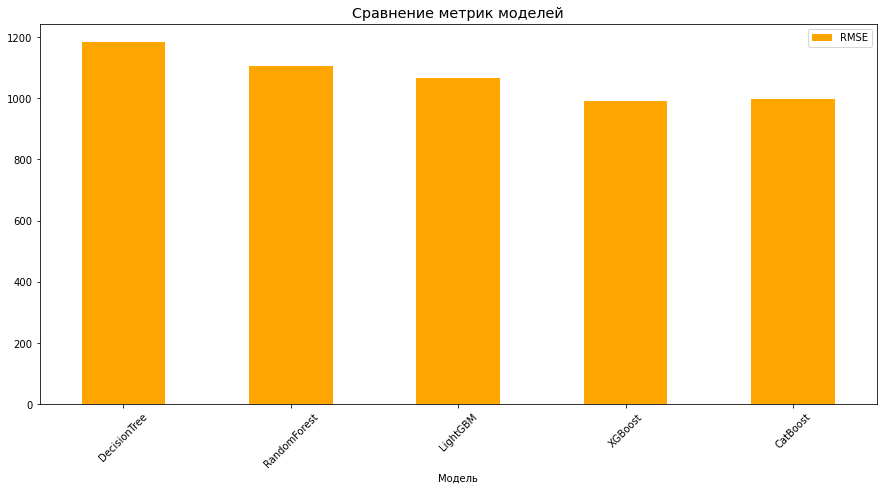

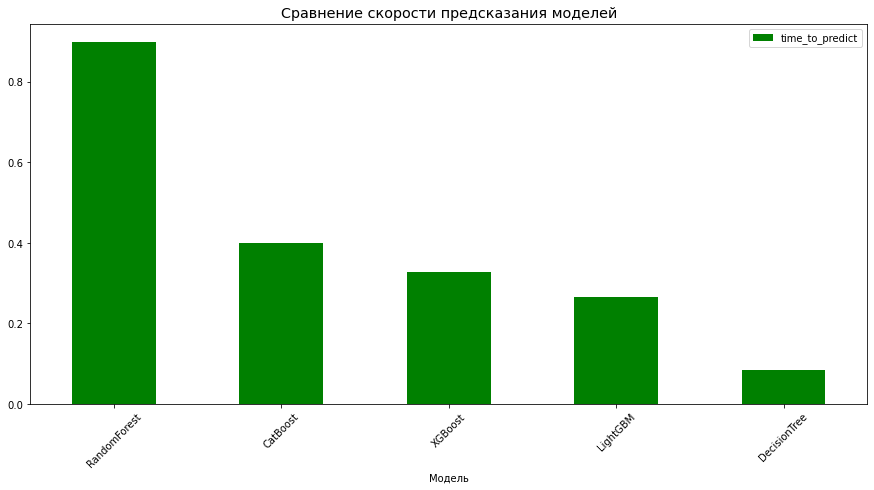

In [48]:
all_names = pd.DataFrame({'names':['DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost', 'CatBoost']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)

analisys.plot.bar(y='RMSE', x='names', rot=45, figsize=(15,7), color='orange')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

analisys.sort_values(by='time_to_predict', ascending=False)\
.plot.bar(y='time_to_predict', x='names', rot=45, figsize=(15,7), color='green')
plt.title('Сравнение скорости предсказания моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

Из полученных моделей выявлено:

* Быстрее всех среди деревянных моделей с рандомными параметрами обучается LightGBM. Самая худшая модель среди всех - линейная регрессия.
* Самые лучшие метрики у CatBoost и XGBoost. Они отличаются незначительно. Но и скорость обучения самая долгая. 
* Самые оптимальные показатели времени предсказания/качества модели - XGBoost.

Стоит выделить именно обученную модель XGBoost и использовать ее.

## Анализ моделей

Рассмотрим скорость обучения на итоговой модели и метрики:

In [50]:
start = time()
predicted = xb_random.predict(test_features)
print('Модель предсказывает не тестовой выборке за %.2f секунд' %(time() - start))

rmse_on_test = mean_squared_error(test_target, predicted, squared=False)
print('Итоговый RMSE на тестовой выборке:', rmse_on_test)

Модель предсказывает не тестовой выборке за 0.11 секунд
Итоговый RMSE на тестовой выборке: 1723.2378462982376


## Вывод

В целом, все модели предсказывают довольно быстро - меньше секунды, но все же для заказчика важна скорость предсказания и метрика, потому лучшая модель - XGBoost с параметрами: `max_depth`: `13`, `learning_rate`: `0.1`.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей